In [166]:
# imports
# usual stuff
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# use of lightgbm:
# documentation: https://lightgbm.readthedocs.io/en/latest/
# Gradient boosting library
# https://en.wikipedia.org/wiki/Gradient_boosting --> short explanation: ensemble weak prediction models to a new one
import lightgbm as lgb

# Encode target labels with value between 0 and n_classes-1.
from sklearn.preprocessing import LabelEncoder

# Provides train/test indices to split data in train/test sets. 
# Split dataset into k consecutive folds (without shuffling by default).
from sklearn.model_selection import KFold

import datetime
import gc

# Define Path and load data

In [104]:
PATH = './data/'

train_df = pd.read_csv(PATH + 'train.csv')

building_df = pd.read_csv(PATH + 'building_metadata.csv')
weather_df = pd.read_csv(PATH + 'weather_train.csv')

# data optimization fuction
 from https://www.kaggle.com/gemartin/load-data-reduce-memory-usage

In [105]:
from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

def reduce_mem_usage(df, use_float16=False):
    start_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage of dataframe is {:.2f} MB".format(start_mem))
    
    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype("category")

    end_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
    print("Decreased by {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))
    
    return df

# Missing data analysis

In [106]:
def missing_statistics(df):    
    statitics = pd.DataFrame(df.isnull().sum()).reset_index()
    statitics.columns=['COLUMN NAME',"MISSING VALUES"]
    statitics['TOTAL ROWS'] = df.shape[0]
    statitics['% MISSING'] = round((statitics['MISSING VALUES']/statitics['TOTAL ROWS'])*100,2)
    return statitics

# fix the weather data
Analyse and manipulate the weather data<br>
code from: https://www.kaggle.com/aitude/ashrae-missing-weather-data-handling

In [107]:
def fill_weather_dataset(weather_df):
    
    # Find Missing Dates
    time_format = "%Y-%m-%d %H:%M:%S"
    start_date = datetime.datetime.strptime(weather_df['timestamp'].min(),time_format)
    end_date = datetime.datetime.strptime(weather_df['timestamp'].max(),time_format)
    total_hours = int(((end_date - start_date).total_seconds() + 3600) / 3600)
    hours_list = [(end_date - datetime.timedelta(hours=x)).strftime(time_format) for x in range(total_hours)]

    missing_hours = []
    for site_id in range(16):
        site_hours = np.array(weather_df[weather_df['site_id'] == site_id]['timestamp'])
        new_rows = pd.DataFrame(np.setdiff1d(hours_list,site_hours),columns=['timestamp'])
        new_rows['site_id'] = site_id
        weather_df = pd.concat([weather_df,new_rows])

        weather_df = weather_df.reset_index(drop=True)           

    # Add new Features
    weather_df["datetime"] = pd.to_datetime(weather_df["timestamp"])
    weather_df["day"] = weather_df["datetime"].dt.day
    weather_df["week"] = weather_df["datetime"].dt.week
    weather_df["month"] = weather_df["datetime"].dt.month
    
    # Reset Index for Fast Update
    weather_df = weather_df.set_index(['site_id','day','month'])

    air_temperature_filler = pd.DataFrame(weather_df.groupby(['site_id','day','month'])['air_temperature'].mean(),columns=["air_temperature"])
    weather_df.update(air_temperature_filler,overwrite=False)

    # Step 1
    cloud_coverage_filler = weather_df.groupby(['site_id','day','month'])['cloud_coverage'].mean()
    # Step 2
    cloud_coverage_filler = pd.DataFrame(cloud_coverage_filler.fillna(method='ffill'),columns=["cloud_coverage"])

    weather_df.update(cloud_coverage_filler,overwrite=False)

    due_temperature_filler = pd.DataFrame(weather_df.groupby(['site_id','day','month'])['dew_temperature'].mean(),columns=["dew_temperature"])
    weather_df.update(due_temperature_filler,overwrite=False)

    # Step 1
    sea_level_filler = weather_df.groupby(['site_id','day','month'])['sea_level_pressure'].mean()
    # Step 2
    sea_level_filler = pd.DataFrame(sea_level_filler.fillna(method='ffill'),columns=['sea_level_pressure'])

    weather_df.update(sea_level_filler,overwrite=False)

    wind_direction_filler =  pd.DataFrame(weather_df.groupby(['site_id','day','month'])['wind_direction'].mean(),columns=['wind_direction'])
    weather_df.update(wind_direction_filler,overwrite=False)

    wind_speed_filler =  pd.DataFrame(weather_df.groupby(['site_id','day','month'])['wind_speed'].mean(),columns=['wind_speed'])
    weather_df.update(wind_speed_filler,overwrite=False)

    # Step 1
    precip_depth_filler = weather_df.groupby(['site_id','day','month'])['precip_depth_1_hr'].mean()
    # Step 2
    precip_depth_filler = pd.DataFrame(precip_depth_filler.fillna(method='ffill'),columns=['precip_depth_1_hr'])

    weather_df.update(precip_depth_filler,overwrite=False)

    weather_df = weather_df.reset_index()
    weather_df = weather_df.drop(['datetime','day','week','month'],axis=1)
        
    return weather_df

In [108]:
weather_df = fill_weather_dataset(weather_df)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  from ipykernel import kernelapp as app


# Reduce Menory Usage to better work with the data

In [109]:
train_df = reduce_mem_usage(train_df,use_float16=True)
building_df = reduce_mem_usage(building_df,use_float16=True)
weather_df = reduce_mem_usage(weather_df,use_float16=True)

Memory usage of dataframe is 616.95 MB
Memory usage after optimization is: 173.90 MB
Decreased by 71.8%
Memory usage of dataframe is 0.07 MB
Memory usage after optimization is: 0.02 MB
Decreased by 73.8%
Memory usage of dataframe is 9.65 MB
Memory usage after optimization is: 2.66 MB
Decreased by 72.5%


# join data together 
### like sql statement

In [110]:
train_df = train_df.merge(building_df, left_on='building_id',right_on='building_id',how='left')
train_df = train_df.merge(weather_df,how='left',left_on=['site_id','timestamp'],right_on=['site_id','timestamp'])

In [111]:
train_df.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01 00:00:00,0.0,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,-0.17395,1019.5,0.0,0.0
1,1,0,2016-01-01 00:00:00,0.0,0,Education,2720,2004.0,NaN,25.0,6.0,20.0,-0.17395,1019.5,0.0,0.0
2,2,0,2016-01-01 00:00:00,0.0,0,Education,5376,1991.0,NaN,25.0,6.0,20.0,-0.17395,1019.5,0.0,0.0
3,3,0,2016-01-01 00:00:00,0.0,0,Education,23685,2002.0,NaN,25.0,6.0,20.0,-0.17395,1019.5,0.0,0.0
4,4,0,2016-01-01 00:00:00,0.0,0,Education,116607,1975.0,NaN,25.0,6.0,20.0,-0.17395,1019.5,0.0,0.0


# let´s try to find the relevant features

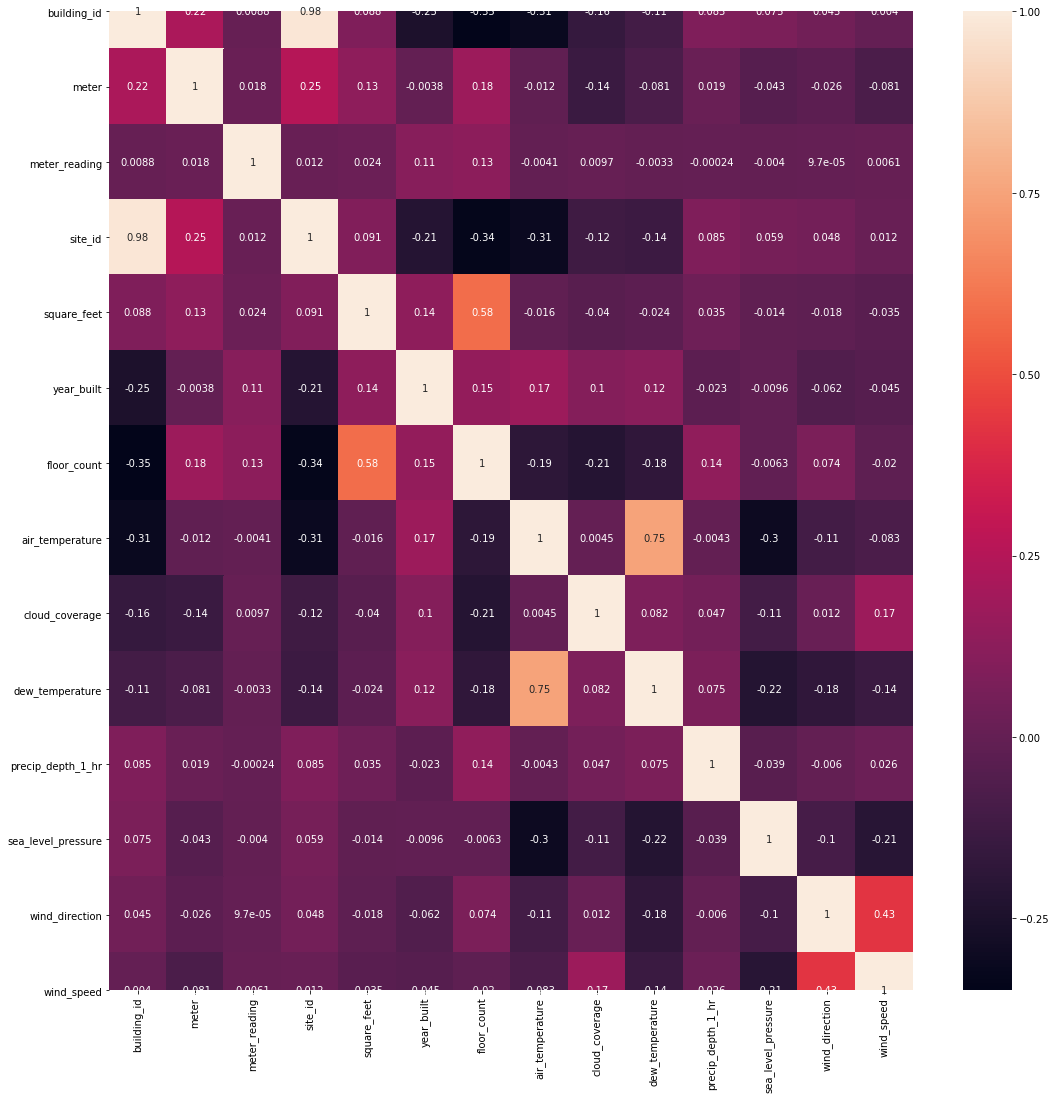

In [23]:
plt.figure(figsize=(18, 18))
# show coorelations in a heatmap
sns.heatmap(train_df.corr(),annot=True)

In [36]:
# missing points
missing_statistics(train_df)

,COLUMN NAME,MISSING VALUES,TOTAL ROWS,% MISSING
0,building_id,0,20216100,0.00
1,meter,0,20216100,0.00
2,timestamp,0,20216100,0.00
3,meter_reading,0,20216100,0.00
4,site_id,0,20216100,0.00
5,primary_use,0,20216100,0.00
6,square_feet,0,20216100,0.00
7,year_built,12127645,20216100,59.99
8,floor_count,16709167,20216100,82.65
9,air_temperature,0,20216100,0.00


In [112]:
# feature selection fuction
def select_features(df_given):
    df = df_given.copy()
    # Sort by timestamp
    df.sort_values("timestamp")
    # reset index
    df.reset_index(drop=True)
    
    # seperate the timestamp into individual features
    df["timestamp"] = pd.to_datetime(df["timestamp"],format="%Y-%m-%d %H:%M:%S")
    df["hour"] = df["timestamp"].dt.hour
    df["weekday"] = df["timestamp"].dt.weekday
    df['square_feet'] =  np.log1p(df['square_feet'])
    
    # remove some stuff
    # floor_count, year_built: no many null values
    drop = [
        'timestamp', 'floor_count', 
        'year_built', 'precip_depth_1_hr', 
        'primary_use', 'wind_speed', 'wind_direction'
    ]
    df = df.drop(drop, axis=1)
    
    # transform the primary usage to a number
    # le = LabelEncoder()
    # df["primary_use"] = le.fit_transform(df["primary_use"])
    
    return df

# copy into new df, to modify from here on later again

In [71]:
train_df_features = select_features(train_df)
train_df_features.head()

,building_id,meter,meter_reading,site_id,square_feet,air_temperature,cloud_coverage,dew_temperature,sea_level_pressure,hour,weekend
0,0,0,0.0,0,0.579334,25.0,6.0,20.0,1019.5,0,4
1,1,0,0.0,0,0.570803,25.0,6.0,20.0,1019.5,0,4
2,2,0,0.0,0,0.576735,25.0,6.0,20.0,1019.5,0,4
3,3,0,0.0,0,0.587674,25.0,6.0,20.0,1019.5,0,4
4,4,0,0.0,0,0.597220,25.0,6.0,20.0,1019.5,0,4


In [72]:
# get target and features
target = np.log1p(train_df_features["meter_reading"])
features = train_df_features.drop('meter_reading', axis = 1)

# Build the model

In [149]:
from datetime import datetime
def build_model(t, f, categorical, params, splits):
    # measure time
    total_start = datetime.now()
    
    # t = target
    # f = features
    # categorical = categorical features of the dataset
    # params = model parameters --> used to change to find best fit
    # splits = kfolf number of splits
    
    kf = KFold(n_splits=splits)
    # collect models
    models = []
    
    for train_index,test_index in kf.split(f):
        model_start = datetime.now()
        # train
        train_features = f.loc[train_index]
        train_target = t.loc[train_index]
        
        # test
        test_features = f.loc[test_index]
        test_target = t.loc[test_index]
        
        d_train = lgb.Dataset(train_features, label=train_target, categorical_feature=categorical, free_raw_data=False)
        d_test = lgb.Dataset(test_features, label=test_target,categorical_feature=categorical, free_raw_data=False)
        # explanation:
        '''
            label: (list, numpy 1-D array, pandas Series / one-column DataFrame or None, optional (default=None)) – Label of the data.
            loading numpy array in the datasettt
            free_raw_data: saves memory if set to true --> i´m not concerned on my pc
            details:
            https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.Dataset.html
        '''
        model = lgb.train(
             params, 
             train_set=d_train, 
             num_boost_round=1000, 
             valid_sets=[d_train,d_test], 
             verbose_eval=25, 
             early_stopping_rounds=50
        )
        # append model to list
        models.append(model)
        del train_features, train_target, test_features, test_target, d_train, d_test
        gc.collect()
        
        model_end = datetime.now()
        print('KFold time:', model_end - model_start)
        
    total_end = datetime.now()
    print('Total time:', total_end - total_start)
    
    return models

# Test with different params

In [64]:
# test 1:
categorical_features = ["building_id", "site_id", "meter", "primary_use", "weekend"]
params = {
    "objective": "regression",
    "boosting": "gbdt",
    "num_leaves": 31,
    "learning_rate": 0.05,
    "feature_fraction": 0.85,
    "reg_lambda": 2,
    "metric": "rmse",
}

test_1 = build_model(target, features, categorical_features, params, 3)

Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 1.48855	valid_1's rmse: 1.87668
[50]	training's rmse: 1.31266	valid_1's rmse: 1.76935
[75]	training's rmse: 1.18062	valid_1's rmse: 1.66561
[100]	training's rmse: 1.10659	valid_1's rmse: 1.61157
[125]	training's rmse: 1.06208	valid_1's rmse: 1.58366
[150]	training's rmse: 1.03167	valid_1's rmse: 1.56251
[175]	training's rmse: 1.01138	valid_1's rmse: 1.54991
[200]	training's rmse: 0.996425	valid_1's rmse: 1.54023
[225]	training's rmse: 0.986502	valid_1's rmse: 1.53385
[250]	training's rmse: 0.977859	valid_1's rmse: 1.5304
[275]	training's rmse: 0.969387	valid_1's rmse: 1.52533
[300]	training's rmse: 0.962705	valid_1's rmse: 1.52214
[325]	training's rmse: 0.956574	valid_1's rmse: 1.51952
[350]	training's rmse: 0.951703	valid_1's rmse: 1.51605
[375]	training's rmse: 0.946359	valid_1's rmse: 1.51284
[400]	training's rmse: 0.942412	valid_1's rmse: 1.51109
[425]	training's rmse: 0.938476	valid_1's rmse: 1.5112

In [57]:
# OK Problems:
'''
    CIRCULAR DEPENDENCY: Fix: remove timstamp --> leads to lower score
        ligtgbm json in background: https://gitmemory.com/issue/microsoft/LightGBM/2134/520261059
    HIGH RMSE: FIX: I´m not using loc in the data --> of cause "meter_reading" is too high
    Training taking forever: FIX: reduce features, measure time
    terrible mistake: no dataframe copy, I manipulated the dataset directly "facepalm"
'''

'\n    CIRCULAR DEPENDENCY: Fix: don´t use a model function\n    HIGH RMSE: FIX: I´m not using loc in the data --> of cause "meter_reading" is too high\n    Training taking forever: FIX: reduce features\n'

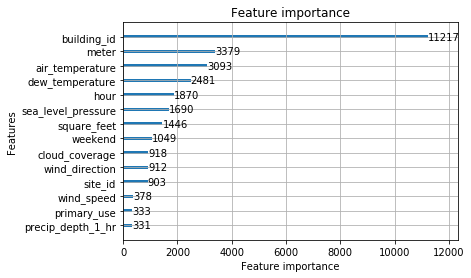

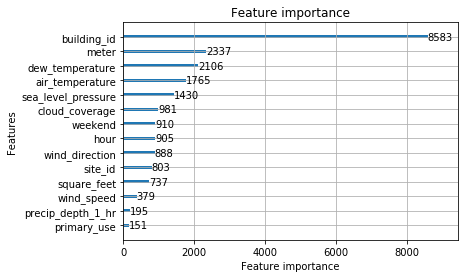

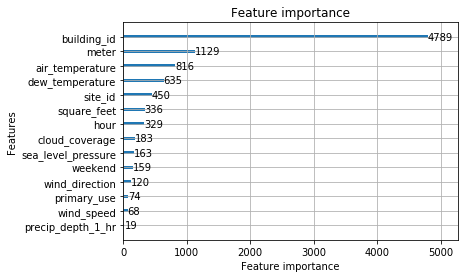

In [66]:
# feature importance
for model in test_1:
    lgb.plot_importance(model)
    plt.show()
    
# remove features:
# 'precip_depth_1_hr', 'primary_use', 'wind_speed', 'wind_direction'

In [77]:
# test 2:
categorical_features = ["building_id", "site_id", "meter", "weekend"]
params = {
    "objective": "regression",
    "boosting": "gbdt",
    "num_leaves": 31,
    "learning_rate": 0.05,
    "feature_fraction": 0.85,
    "reg_lambda": 2,
    "metric": "rmse",
}

test_2 = build_model(target, features, categorical_features, params, 3)

Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 1.49363	valid_1's rmse: 1.89969
[50]	training's rmse: 1.29377	valid_1's rmse: 1.75164
[75]	training's rmse: 1.17448	valid_1's rmse: 1.66001
[100]	training's rmse: 1.10901	valid_1's rmse: 1.61186
[125]	training's rmse: 1.05645	valid_1's rmse: 1.57725
[150]	training's rmse: 1.02584	valid_1's rmse: 1.55538
[175]	training's rmse: 1.00469	valid_1's rmse: 1.54652
[200]	training's rmse: 0.990733	valid_1's rmse: 1.53958
[225]	training's rmse: 0.98086	valid_1's rmse: 1.53553
[250]	training's rmse: 0.97179	valid_1's rmse: 1.53262
[275]	training's rmse: 0.96156	valid_1's rmse: 1.53069
[300]	training's rmse: 0.952962	valid_1's rmse: 1.52926
[325]	training's rmse: 0.946988	valid_1's rmse: 1.52792
[350]	training's rmse: 0.941398	valid_1's rmse: 1.52601
[375]	training's rmse: 0.936937	valid_1's rmse: 1.52541
[400]	training's rmse: 0.933112	valid_1's rmse: 1.52583
[425]	training's rmse: 0.930292	valid_1's rmse: 1.52586


In [156]:
# OK, little better, but there is room for improvement
# try to build better features

# holiday calendar import --> some kernels say that all buildings are located in the US
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

def select_features_new(df_given, drop_cols, build_lags_for, window=3):
    df = df_given.copy()
    # Sort by timestamp
    df.sort_values("timestamp")
    # reset index
    df.reset_index(drop=True)
    
    # seperate the timestamp into individual features
    df["timestamp"] = pd.to_datetime(df["timestamp"],format="%Y-%m-%d %H:%M:%S")
    
    df['hour'] = np.uint8(df['timestamp'].dt.hour)
    df['day'] = np.uint8(df['timestamp'].dt.day)
    df['weekday'] = np.uint8(df['timestamp'].dt.weekday)
    df['month'] = np.uint8(df['timestamp'].dt.month)
    
    df['square_feet'] =  np.log1p(df['square_feet'])
    
    # build in holiday feature
    min_date = pd.to_datetime(df["timestamp"].iloc[0],format="%Y-%m-%d")
    max_date = pd.to_datetime(df["timestamp"].iloc[-1],format="%Y-%m-%d")
    
    date_range = pd.date_range(start=min_date, end=max_date)
    us_holidays = calendar().holidays(start=date_range.min(), end=date_range.max())
    
    df['is_holiday'] = (df['timestamp'].dt.date.astype('datetime64').isin(us_holidays)).astype(np.int8)
    
    # build weekend classification (weekday starts at 0)
    df['is_weekend'] = np.where( (df["weekday"] == 5) | (df["weekday"] == 6), 1, 0 )
    
    # build lags
    if build_lags_for:
        rolled = df[build_lags_for].rolling(window=window, min_periods=0)
        lag_mean = rolled.mean().reset_index().astype(np.float16)
        lag_std = rolled.std().reset_index().astype(np.float16)
        
        for col in build_lags_for:
            df[f'{col}_mean_lag{window}'] = lag_mean[col]
        
    df = df.drop(drop_cols, axis=1)
    
    # transform the primary usage to a number
    le = LabelEncoder()
    df["primary_use"] = le.fit_transform(df["primary_use"])
    
    gc.collect()
    return df

In [146]:
train_df_features_new = select_features_new(
    train_df,
    ['timestamp', 'floor_count', 'year_built', 'precip_depth_1_hr', 'wind_speed', 'wind_direction']
    false
)

In [147]:
train_df_features_new.head()

,building_id,meter,meter_reading,site_id,primary_use,square_feet,air_temperature,cloud_coverage,dew_temperature,sea_level_pressure,hour,day,weekday,month,is_holiday,is_weekend
0,0,0,0.0,0,0,8.913685,25.0,6.0,20.0,1019.5,0,1,4,1,1,0
1,1,0,0.0,0,0,7.908755,25.0,6.0,20.0,1019.5,0,1,4,1,1,0
2,2,0,0.0,0,0,8.589886,25.0,6.0,20.0,1019.5,0,1,4,1,1,0
3,3,0,0.0,0,0,10.072639,25.0,6.0,20.0,1019.5,0,1,4,1,1,0
4,4,0,0.0,0,0,11.666573,25.0,6.0,20.0,1019.5,0,1,4,1,1,0


In [150]:
# new model
# get target and features
target = np.log1p(train_df_features_new["meter_reading"])
features = train_df_features_new.drop('meter_reading', axis = 1)

# test 3:
categorical_features = [
    "building_id", "site_id", 'primary_use', 
    'hour', 'weekday', 'meter',
    'is_holiday', 'is_weekend'
]
params = {
    "objective": "regression",
    "boosting": "gbdt",
    "num_leaves": 31,
    "learning_rate": 0.05,
    "feature_fraction": 0.85,
    "reg_lambda": 2,
    "metric": "rmse",
}

test_3 = build_model(target, features, categorical_features, params, 3)

/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 1.486	valid_1's rmse: 1.86474
[50]	training's rmse: 1.2943	valid_1's rmse: 1.71986
[75]	training's rmse: 1.15997	valid_1's rmse: 1.59617
[100]	training's rmse: 1.07037	valid_1's rmse: 1.48631
[125]	training's rmse: 1.01186	valid_1's rmse: 1.42433
[150]	training's rmse: 0.971065	valid_1's rmse: 1.38214
[175]	training's rmse: 0.940706	valid_1's rmse: 1.34981
[200]	training's rmse: 0.919721	valid_1's rmse: 1.32775
[225]	training's rmse: 0.899589	valid_1's rmse: 1.31692
[250]	training's rmse: 0.887003	valid_1's rmse: 1.30726
[275]	training's rmse: 0.876115	valid_1's rmse: 1.30375
[300]	training's rmse: 0.865782	valid_1's rmse: 1.29791
[325]	training's rmse: 0.856577	valid_1's rmse: 1.29638
[350]	training's rmse: 0.849991	valid_1's rmse: 1.2961
[375]	training's rmse: 0.842217	valid_1's rmse: 1.29195
[400]	training's rmse: 0.83653	valid_1's rmse: 1.2894
[425]	training's rmse: 0.830264	valid_1's rmse: 1.28348
[

In [157]:
# OK, next test, I´ve modified the feature function to accept drops and lag building
train_df_features_new = select_features_new(
    train_df,
    ["timestamp","sea_level_pressure", "wind_direction", "wind_speed","year_built","floor_count"],
    ['air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr'],
    window=72
)

In [158]:
train_df_features_new.head()

,building_id,meter,meter_reading,site_id,primary_use,square_feet,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,hour,day,weekday,month,is_holiday,is_weekend,air_temperature_mean_lag72,cloud_coverage_mean_lag72,dew_temperature_mean_lag72,precip_depth_1_hr_mean_lag72
0,0,0,0.0,0,0,8.913685,25.0,6.0,20.0,-0.17395,0,1,4,1,1,0,25.0,6.0,20.0,-0.17395
1,1,0,0.0,0,0,7.908755,25.0,6.0,20.0,-0.17395,0,1,4,1,1,0,25.0,6.0,20.0,-0.17395
2,2,0,0.0,0,0,8.589886,25.0,6.0,20.0,-0.17395,0,1,4,1,1,0,25.0,6.0,20.0,-0.17395
3,3,0,0.0,0,0,10.072639,25.0,6.0,20.0,-0.17395,0,1,4,1,1,0,25.0,6.0,20.0,-0.17395
4,4,0,0.0,0,0,11.666573,25.0,6.0,20.0,-0.17395,0,1,4,1,1,0,25.0,6.0,20.0,-0.17395


In [159]:
# new model
# get target and features
target = np.log1p(train_df_features_new["meter_reading"])
features = train_df_features_new.drop('meter_reading', axis = 1)

# test 4:
categorical_features = [
    "building_id", "site_id", 'primary_use', 
    'hour', 'weekday', 'meter',
    'is_holiday', 'is_weekend'
]
params = {
    "objective": "regression",
    "boosting": "gbdt",
    "num_leaves": 31,
    "learning_rate": 0.05,
    "feature_fraction": 0.85,
    "reg_lambda": 2,
    "metric": "rmse",
}

test_4 = build_model(target, features, categorical_features, params, 3)

/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 1.50189	valid_1's rmse: 1.86907
[50]	training's rmse: 1.29953	valid_1's rmse: 1.74109
[75]	training's rmse: 1.16238	valid_1's rmse: 1.61008
[100]	training's rmse: 1.07263	valid_1's rmse: 1.46524
[125]	training's rmse: 1.02118	valid_1's rmse: 1.40786
[150]	training's rmse: 0.981316	valid_1's rmse: 1.35636
[175]	training's rmse: 0.947266	valid_1's rmse: 1.32925
[200]	training's rmse: 0.923219	valid_1's rmse: 1.30577
[225]	training's rmse: 0.901918	valid_1's rmse: 1.29435
[250]	training's rmse: 0.887006	valid_1's rmse: 1.28424
[275]	training's rmse: 0.874821	valid_1's rmse: 1.27854
[300]	training's rmse: 0.862801	valid_1's rmse: 1.27698
[325]	training's rmse: 0.853998	valid_1's rmse: 1.27508
[350]	training's rmse: 0.846859	valid_1's rmse: 1.27236
[375]	training's rmse: 0.838701	valid_1's rmse: 1.26813
[400]	training's rmse: 0.833989	valid_1's rmse: 1.26633
[425]	training's rmse: 0.829261	valid_1's rmse: 1.2

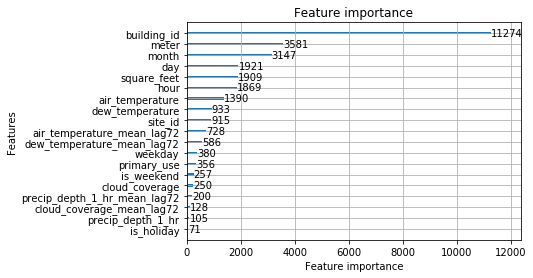

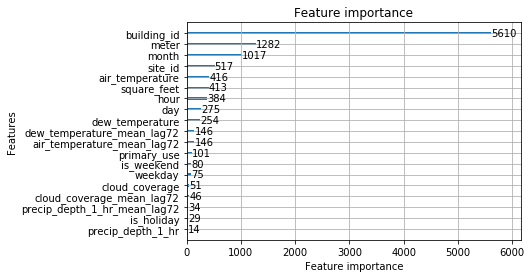

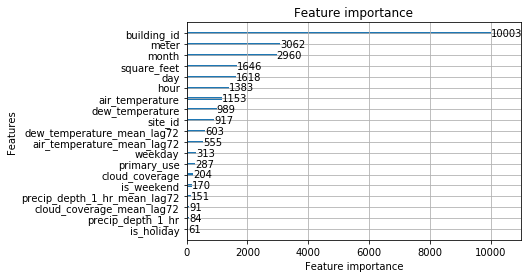

In [160]:
# OK, some improvement
# let´s see the feature importance
for model in test_4:
    lgb.plot_importance(model)
    plt.show()

# let´s try to predict
### load test data

In [162]:
test_df = pd.read_csv(PATH + 'test.csv')
row_ids = test_df["row_id"]
test_df.drop("row_id", axis=1, inplace=True)
test_df = reduce_mem_usage(test_df)

Memory usage of dataframe is 954.38 MB
Memory usage after optimization is: 199.59 MB
Decreased by 79.1%


In [163]:
# merge data
test_df = test_df.merge(building_df,left_on='building_id',right_on='building_id',how='left')

In [167]:
# fill weather
weather_df = pd.read_csv(PATH + 'weather_test.csv')
weather_df = fill_weather_dataset(weather_df)
weather_df = reduce_mem_usage(weather_df)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  from ipykernel import kernelapp as app


Memory usage of dataframe is 19.25 MB
Memory usage after optimization is: 9.05 MB
Decreased by 53.0%


In [168]:
# merge weather
test_df = test_df.merge(weather_df,how='left',on=['timestamp','site_id'])

In [174]:
# get the same features
test_df_features_new = select_features_new(
    test_df,
    ["timestamp","sea_level_pressure", "wind_direction", "wind_speed","year_built","floor_count"],
    ['air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr'],
    window=72
)

In [179]:
test_df_features_new.head()

,building_id,meter,site_id,primary_use,square_feet,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,hour,day,weekday,month,is_holiday,is_weekend,air_temperature_mean_lag72,cloud_coverage_mean_lag72,dew_temperature_mean_lag72,precip_depth_1_hr_mean_lag72
0,0,0,0,0,8.913685,17.799999,4.0,11.7,0.282609,0,1,6,1,0,1,17.796875,4.0,11.703125,0.282715
1,1,0,0,0,7.908755,17.799999,4.0,11.7,0.282609,0,1,6,1,0,1,17.796875,4.0,11.703125,0.282715
2,2,0,0,0,8.589886,17.799999,4.0,11.7,0.282609,0,1,6,1,0,1,17.796875,4.0,11.703125,0.282715
3,3,0,0,0,10.072639,17.799999,4.0,11.7,0.282609,0,1,6,1,0,1,17.796875,4.0,11.703125,0.282715
4,4,0,0,0,11.666573,17.799999,4.0,11.7,0.282609,0,1,6,1,0,1,17.796875,4.0,11.703125,0.282715


In [183]:
# predict
from datetime import datetime as dt
prediction_start = dt.now()

results = []
for model in test_4:
    if  results == []:
        results = np.expm1(model.predict(test_df_features_new, num_iteration=model.best_iteration)) / len(test_4)
    else:
        results += np.expm1(model.predict(test_df_features_new, num_iteration=model.best_iteration)) / len(test_4)
    del model
    gc.collect()
    
print('Prediction Time:', dt.now() - prediction_start)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  import sys


Prediction Time: 0:10:06.659506


In [185]:
# Submission
results_df = pd.DataFrame({"row_id": row_ids, "meter_reading": np.clip(results, 0, a_max=None)})
results_df.to_csv("submission_01.csv", index=False)

In [184]:
print(results)

[ 5.46656946e-01  5.91782483e-01 -3.30859546e-02 ...  2.91255664e+00
  1.29821237e+02  3.29114778e+00]


In [186]:
results_df.head(20)

,row_id,meter_reading
0,0,0.546657
1,1,0.591782
2,2,0.000000
3,3,1.014157
4,4,0.486162
5,5,0.128595
6,6,0.605027
7,7,1.207573
8,8,422.655443
9,9,0.736234
